<a href="https://colab.research.google.com/github/pstjohn/gnn-codecamp/blob/main/cetane_number_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Enabling the GPU

First, you'll need to enable GPUs for the notebook:

- Navigate to Edit→Notebook Settings
- select GPU from the Hardware Accelerator drop-down

In [1]:
!pip install rdkit-pypi

     |████████████████████████████████| 18.6 MB 1.3 MB/s 


In [2]:
import numpy as np
import pandas as pd

import rdkit
from rdkit.Chem import AllChem

In [3]:
cn_data = pd.read_csv('https://raw.githubusercontent.com/pstjohn/gnn-codecamp/main/cn.csv')
cn_data.head()

,SMILES,IUPAC name,CN,Device
0,CCCCCCC,heptane,57.600,AFIDA
1,CCCCCCCCCCCCO,dodecan-1-ol,51.605,AFIDA
2,CCCC=O,butanal,38.315,AFIDA
3,CC1CCCCC1,methylcyclohexane,17.355,AFIDA
4,CC(C)CC(C)(C)C,"2,2,4-trimethylpentane",5.200,AFIDA


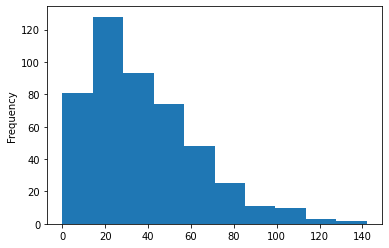

In [4]:
cn_data.CN.plot.hist()

In [5]:
cn_data['CN'] = cn_data.CN.clip(upper=100)

In [6]:
cn_test = cn_data.sample(frac=0.2, random_state=42)
cn_train = cn_data[~cn_data.index.isin(cn_test.index)]

In [7]:
def get_morgan_fingerprint(smiles, radius=2, nBits=1024):
  mol = rdkit.Chem.MolFromSmiles(smiles)
  bv = AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits=nBits)
  return np.asarray(bv)

def get_all_fingerprints(smiles_series):
  fingerprints = np.vstack(smiles_series.apply(get_morgan_fingerprint).values)
  return fingerprints

In [8]:
fingerprints_train = get_all_fingerprints(cn_train.SMILES)
fingerprints_test = get_all_fingerprints(cn_test.SMILES)

In [9]:
%tensorflow_version 2.x
import tensorflow as tf
from tensorflow.keras import layers
tf.__version__

'2.5.0'

In [10]:
input = layers.Input(shape=(1024), name='fingerprint', dtype='int64')
out = layers.Dense(128, activation='relu')(input)
out = layers.BatchNormalization()(out)
out = layers.Dense(64, activation='relu')(out)
out = layers.BatchNormalization()(out)
out = layers.Dense(1)(out)

mlp_model = tf.keras.Model(input, out)

In [11]:
opt = tf.keras.optimizers.Adam(learning_rate=1E-2)
mlp_model.compile(optimizer=opt, loss='mae')

In [12]:
hist = mlp_model.fit(x=fingerprints_train, y=cn_train.CN,
                     validation_data=(fingerprints_test, cn_test.CN),
                     epochs=30, batch_size=32, verbose=2)

Epoch 1/30
12/12 - 4s - loss: 36.5374 - val_loss: 35.7385
Epoch 2/30
12/12 - 0s - loss: 33.7969 - val_loss: 29.0149
Epoch 3/30
12/12 - 0s - loss: 28.6582 - val_loss: 19.6521
Epoch 4/30
12/12 - 0s - loss: 21.0990 - val_loss: 19.1395
Epoch 5/30
12/12 - 0s - loss: 12.8337 - val_loss: 28.4309
Epoch 6/30
12/12 - 0s - loss: 10.3609 - val_loss: 23.4249
Epoch 7/30
12/12 - 0s - loss: 8.6291 - val_loss: 25.8142
Epoch 8/30
12/12 - 0s - loss: 7.2522 - val_loss: 15.5921
Epoch 9/30
12/12 - 0s - loss: 7.0349 - val_loss: 21.7478
Epoch 10/30
12/12 - 0s - loss: 6.8082 - val_loss: 16.4362
Epoch 11/30
12/12 - 0s - loss: 7.3357 - val_loss: 21.6168
Epoch 12/30
12/12 - 0s - loss: 6.7724 - val_loss: 12.3016
Epoch 13/30
12/12 - 0s - loss: 7.4821 - val_loss: 13.7217
Epoch 14/30
12/12 - 0s - loss: 6.6015 - val_loss: 14.5864
Epoch 15/30
12/12 - 0s - loss: 6.1206 - val_loss: 12.0323
Epoch 16/30
12/12 - 0s - loss: 6.3363 - val_loss: 12.0013
Epoch 17/30
12/12 - 0s - loss: 6.1902 - val_loss: 11.7633
Epoch 18/30
12/12

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

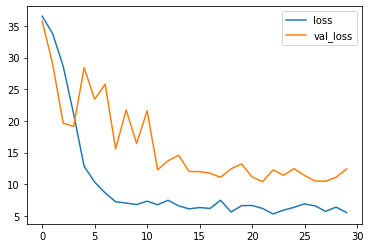

In [14]:
pd.DataFrame(hist.history).plot.line()

In [15]:
mlp_model.predict(get_morgan_fingerprint('CC(C)COCC(C)C').reshape(1, -1))

array([[61.117344]], dtype=float32)

In [16]:
!pip install nfp

In [17]:
import nfp
from collections import namedtuple

atom_type = namedtuple('Atom', ['symbol', 'aromatic', 'ring_size', 'degree', 'totalHs'])
bond_type = namedtuple('Bond', ['bond_type', 'degree', 'ring_size'])

def atom_featurizer(atom):
    """ Return an string representing the atom type
    """

    return atom_type(
        atom.GetSymbol(),
        atom.GetIsAromatic(),
        nfp.get_ring_size(atom, max_size=6),
        atom.GetDegree(),
        atom.GetTotalNumHs(includeNeighbors=True)
    )

def bond_featurizer(bond, flipped=False):
    """ Get a similar classification of the bond type.
    Flipped indicates which 'direction' the bond edge is pointing. """
    
    if not flipped:
        atoms = "{}-{}".format(
            *tuple((bond.GetBeginAtom().GetSymbol(),
                    bond.GetEndAtom().GetSymbol())))
    else:
        atoms = "{}-{}".format(
            *tuple((bond.GetEndAtom().GetSymbol(),
                    bond.GetBeginAtom().GetSymbol())))
    
    btype = str(bond.GetBondType())
    ring = nfp.get_ring_size(bond, max_size=6) if bond.IsInRing() else None
    
    return bond_type(atoms, btype, ring)

In [18]:
mol = rdkit.Chem.MolFromSmiles('CC(C)COCC(C)C')

In [19]:
atom_featurizer(mol.GetAtoms()[0])

Atom(symbol='C', aromatic=False, ring_size=0, degree=1, totalHs=3)

In [20]:
bond_featurizer(mol.GetBonds()[0])

Bond(bond_type='C-C', degree='SINGLE', ring_size=None)

In [21]:
preprocessor = nfp.SmilesPreprocessor(atom_features=atom_featurizer,
                                      bond_features=bond_featurizer,
                                      explicit_hs=False)

In [22]:
pd.Series(preprocessor.atom_tokenizer._data)

unk    1
dtype: int64

In [23]:
for smiles in cn_train.SMILES: 
  preprocessor.construct_feature_matrices(smiles, train=True)

In [24]:
pd.Series(preprocessor.atom_tokenizer._data)

unk                       1
(C, False, 0, 1, 3)       2
(C, False, 0, 2, 2)       3
(O, False, 0, 1, 1)       4
(C, False, 0, 2, 1)       5
(O, False, 0, 1, 0)       6
(C, False, max, 3, 1)     7
(C, False, max, 2, 2)     8
(C, False, 0, 3, 1)       9
(C, False, 0, 4, 0)      10
(O, False, 0, 2, 0)      11
(C, False, 0, 3, 0)      12
(C, False, 4, 4, 0)      13
(C, False, 4, 2, 2)      14
(O, False, 4, 2, 0)      15
(C, False, 0, 1, 2)      16
(C, False, 5, 2, 2)      17
(C, False, max, 2, 1)    18
(C, True, max, 3, 0)     19
(C, True, max, 2, 1)     20
(C, True, 5, 3, 0)       21
(C, False, 5, 3, 1)      22
(O, False, 5, 2, 0)      23
(C, True, 5, 2, 1)       24
(O, True, 5, 2, 0)       25
(C, False, max, 3, 0)    26
(C, False, 4, 3, 1)      27
(O, False, max, 2, 0)    28
(C, False, max, 4, 0)    29
(C, False, 0, 1, 1)      30
(C, False, 0, 2, 0)      31
(C, False, 3, 3, 1)      32
(C, False, 3, 4, 0)      33
(C, False, 5, 3, 0)      34
(C, False, 5, 2, 1)      35
(C, False, 5, 4, 0) 

In [25]:
preprocessor.construct_feature_matrices('CCO', train=False)['atom']

array([2, 3, 4])

In [26]:
preprocessor.construct_feature_matrices('CCO', train=False)['bond']

array([2, 2, 3, 4])

In [27]:
preprocessor.construct_feature_matrices('CCO', train=False)['connectivity']

array([[0, 1],
       [1, 0],
       [1, 2],
       [2, 1]])

In [28]:
def data_generator(cn_split):
  for _, row in cn_split.iterrows():
    inputs = preprocessor.construct_feature_matrices(row.SMILES, train=False)
    yield ({'atom': inputs['atom'],
            'bond': inputs['bond'],
            'connectivity': inputs['connectivity']},
           row.CN)

output_signature = (
    {'atom': tf.TensorSpec(shape=(None,), dtype=tf.int32),
     'bond': tf.TensorSpec(shape=(None,), dtype=tf.int32),
     'connectivity': tf.TensorSpec(shape=(None, 2), dtype=tf.int32)},
    tf.TensorSpec(shape=(), dtype=tf.float32))

In [29]:
train_dataset = tf.data.Dataset.from_generator(
    lambda: data_generator(cn_train),
    output_signature=output_signature)\
    .cache().shuffle(buffer_size=200)\
    .padded_batch(batch_size=32)\
    .prefetch(tf.data.experimental.AUTOTUNE)

valid_dataset = tf.data.Dataset.from_generator(
    lambda: data_generator(cn_test),
    output_signature=output_signature)\
    .cache().shuffle(buffer_size=200)\
    .padded_batch(batch_size=32)\
    .prefetch(tf.data.experimental.AUTOTUNE)

In [30]:
for inputs, outputs in train_dataset.as_numpy_iterator():
  break

inputs['atom']

array([[ 2,  3,  3,  3,  3,  9,  4,  3,  3,  2,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0],
       [ 2,  3,  5,  5,  3,  3,  3,  2,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0],
       [ 2,  3,  3,  3,  3,  3,  3,  3,  3,  4,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0],
       [18, 18,  8,  8,  8,  8,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0],
       [ 2, 19, 20, 20, 20, 19,  2, 19,  2,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0],
       [16,  5,  3,  3,  3,  3,  3,  3,  3,  3,  3,  2,  0,  0,  0,  0,
         0,  0,  0,  0,  0],
       [ 2,  9,  2, 11,  9,  2,  2,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0],
       [ 2,  3, 19, 20, 20, 20, 20, 20,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0],
       [ 2,  9,  2, 10,  2,  2,  2,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0],
       [16,  5, 12,  2,  5,  3,  5, 12,  2,  3,  3,  5, 12,  2,  2,  0,
         0,  0,  0,

In [31]:
outputs

array([ 28.   ,  34.   ,  46.2  ,  18.1  ,  10.14 ,  56.8  ,   2.128,
         6.29 ,  12.9  ,  31.72 ,  10.4  ,  70.   ,  22.96 ,  13.1  ,
        36.   ,   8.   ,  21.9  ,  85.1  ,  10.2  , 100.   ,  24.04 ,
        84.095, 100.   ,  16.375,  38.8  ,  19.3  ,  55.345,  24.65 ,
        58.   ,  30.5  ,  41.1  , 100.   ], dtype=float32)

In [65]:
atom = layers.Input(shape=[None], dtype=tf.int32, name='atom')
bond = layers.Input(shape=[None], dtype=tf.int32, name='bond')
connectivity = layers.Input(shape=[None, 2], dtype=tf.int32, name='connectivity')


num_features = 128

atom_state = layers.Embedding(preprocessor.atom_classes, num_features,
                              name='atom_embedding', mask_zero=True)(atom)

bond_state = layers.Embedding(preprocessor.bond_classes, num_features,
                              name='bond_embedding', mask_zero=True)(bond)

atom_mean = layers.Embedding(preprocessor.atom_classes, 1,
                             name='atom_mean', mask_zero=True)(atom)

for _ in range(6):
  new_bond_state = nfp.EdgeUpdate()([atom_state, bond_state, connectivity])
  bond_state = layers.Add()([bond_state, new_bond_state])

  new_atom_state = nfp.NodeUpdate()([atom_state, bond_state, connectivity])
  atom_state = layers.Add()([atom_state, new_atom_state])

atomwise_prediction = layers.Dense(1)(atom_state)
atomwise_prediction = layers.Add()([atomwise_prediction, atom_mean])
mol_prediction = layers.GlobalAveragePooling1D()(atomwise_prediction)

gnn_model = tf.keras.Model([atom, bond, connectivity], [mol_prediction])

In [50]:
!pip install -U tensorflow-addons
import tensorflow_addons as tfa

In [66]:
optimizer = tfa.optimizers.AdamW(learning_rate=1E-4, weight_decay=1E-5)
gnn_model.compile(optimizer, loss='mae')

In [67]:
hist = gnn_model.fit(train_dataset, validation_data=valid_dataset, epochs=50, verbose=2)

Epoch 1/50
12/12 - 10s - loss: 28.3225 - val_loss: 20.0013
Epoch 2/50
12/12 - 0s - loss: 15.7225 - val_loss: 16.0995
Epoch 3/50
12/12 - 0s - loss: 13.7863 - val_loss: 13.0886
Epoch 4/50
12/12 - 0s - loss: 12.5590 - val_loss: 11.9766
Epoch 5/50
12/12 - 0s - loss: 11.8974 - val_loss: 11.0293
Epoch 6/50
12/12 - 0s - loss: 10.9250 - val_loss: 10.4935
Epoch 7/50
12/12 - 0s - loss: 10.1757 - val_loss: 10.9308
Epoch 8/50
12/12 - 0s - loss: 11.0039 - val_loss: 11.0373
Epoch 9/50
12/12 - 0s - loss: 10.1954 - val_loss: 9.3493
Epoch 10/50
12/12 - 0s - loss: 9.5615 - val_loss: 9.4898
Epoch 11/50
12/12 - 0s - loss: 9.3116 - val_loss: 9.8900
Epoch 12/50
12/12 - 0s - loss: 9.5327 - val_loss: 11.1258
Epoch 13/50
12/12 - 0s - loss: 9.1660 - val_loss: 9.8397
Epoch 14/50
12/12 - 0s - loss: 8.7033 - val_loss: 8.3584
Epoch 15/50
12/12 - 0s - loss: 8.9833 - val_loss: 9.5851
Epoch 16/50
12/12 - 0s - loss: 8.7066 - val_loss: 8.6730
Epoch 17/50
12/12 - 0s - loss: 8.2686 - val_loss: 8.9928
Epoch 18/50
12/12 - 0

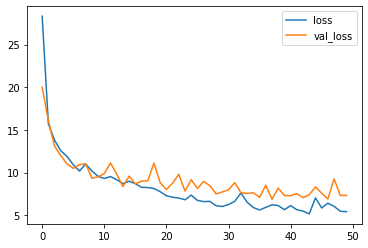

In [68]:
pd.DataFrame(hist.history).plot.line()

In [71]:
nfp.preprocessing.fil

<module 'nfp.preprocessing' from '/usr/local/lib/python3.7/dist-packages/nfp/preprocessing/__init__.py'>

In [77]:
np.expand_dims(inputs['connectivity'], axis=0).shape

(1, 16, 2)

In [78]:
inputs = preprocessor.construct_feature_matrices('CC(C)COCC(C)C')
gnn_model.predict({key: np.expand_dims(inputs[key], axis=0) for key in ['atom', 'bond', 'connectivity']})

array([[67.96338]], dtype=float32)